In [22]:
#pip install --user ipykernel
#python -m ipykernel install --user --name=hope
#conda install pandas
#conda install nibabel
#conda install sklearn # didn't work
#conda install matplotlib
#conda install scikit-learn

In [15]:
import os
import numpy as np
import pandas as pd
import nibabel as nib

#import torchvision.transforms as transforms
#from torchvision.transforms import Compose, ToTensor
from torch.utils.data import Dataset, DataLoader, Subset, RandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("torch_version:                    ", torch.__version__)
print("torch.cuda.is_available?:         ", torch.cuda.is_available())
import sys
print("python version:                   ", sys.version)

a = torch.rand(10).to(device) 
print(a)

torch_version:                     1.13.1
torch.cuda.is_available?:          False
python version:                    3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
tensor([0.9333, 0.0315, 0.8312, 0.2268, 0.7970, 0.0024, 0.5471, 0.3986, 0.0863,
        0.9345])


## Load the table containing participants' information

In [16]:
table = pd.read_csv('/project_space/ADNI_ROY/scripts/adni_table_all_256_crop.csv')
#print(table.head(10))
pd.set_option('display.max_colwidth', None)

##  Load the Dataset

In [17]:
class NeuroImagingDataset(Dataset):
    def __init__(self, data_df, transform = None):
        self.data_df = data_df
        self.transform = transform
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, idx):
        print('0. Loading: data_df:', self.data_df)
        img_path = self.data_df.iloc[idx]['Path']
        print('1. Loading: image_path:', img_path)
        label = self.data_df.iloc[idx]['DX_original']
        print('2. Loading: label:', label) 
        class_label = {'CN': 0, 'Dementia': 1, 'MCI': 2}
        print('3. Loading: class_label', class_label)
        label = class_label[label]
        print('4. Loading: label', label)
        label = F.one_hot(torch.tensor(label), num_classes=3)    
        print('5. Loading: label:', label)     
        img = nib.load(img_path) 
        print('6-1. Loading: img = nib.load(img_path):', img) 
        print('6-2. Loading: img.shape:', img.shape) 
        img = img.get_fdata() # get the image data as a numpy array
        print('7. Loading: img.get_fdata():', img)
        print('what?????',img[128])
        print('7-1. Loading: img.get_fdata.shape',img.shape)
        img_min = img.min()
        print('8. Loading: img_min:', img_min)
        img_max = img.max()
        print('9. Loading: img_max',img_max)
        print('img_max:',img_max)
        
        img = img/img_max
        print(f"image min: {img.min()}, max: {img.max()}") # print the minimum and maximum values in the image
        img =torch.from_numpy(img).unsqueeze(0) 
        # convert the image to a tensor and add channel dimension#???????
 
      
        if self.transform is not None:
            img = self.transform(img)
            print('4.self.transform:', img)
            #augmenting (not augmeting)
            print(img.shape)
        #def image_shape(self):
        #    return utils.load_nifti(self.img_path[0]).shape
          
        return img, label

In [18]:
class NeuroImagingDataset(Dataset):
    def __init__(self, data_df, transform = None):
        self.data_df = data_df
        self.transform = transform
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, idx):
        img_path = self.data_df.iloc[idx]['Path']
  
        label = self.data_df.iloc[idx]['DX_original']
   
        class_label = {'CN': 0, 'Dementia': 1, 'MCI': 2}
   
        label = class_label[label]
    
        label = F.one_hot(torch.tensor(label), num_classes=3)    
      
        img = nib.load(img_path) 
       
        img = img.get_fdata() # get the image data as a numpy array
    

        img_min = img.min()
    
        img_max = img.max()
      
        
        img = img/img_max
        print(f"image min: {img.min()}, max: {img.max()}") # print the minimum and maximum values in the image
        img =torch.from_numpy(img).unsqueeze(0) 
        # convert the image to a tensor and add channel dimension#???????
 
      
        if self.transform is not None:
            img = self.transform(img)
            print('4.self.transform:', img)
            #augmenting (not augmeting)
            print(img.shape)
        #def image_shape(self):
        #    return utils.load_nifti(self.img_path[0]).shape
          
        return img, label

In [19]:
sorted_table = table.sort_values(by = ['PTID','EXAMDATE'])
unique_subjects = sorted_table['PTID'].unique()
print('Subjects N =', len(unique_subjects))
print('Image N    =', len(table))
print('')
class_counts = sorted_table['DX_original'].value_counts()
print(class_counts)
print('')

num_train=int(0.80 * len(unique_subjects))
train_subj = unique_subjects[0:num_train]
image_count_train = table[table['PTID'].isin(train_subj)]['PTID'].value_counts()
total_train_images = image_count_train.sum()


num_test = int(0.1 * len(unique_subjects))
test_subj = unique_subjects[num_train:(num_train+num_test)]
image_count_test = table[table['PTID'].isin(test_subj)]['PTID'].value_counts()
total_test_images = image_count_test.sum()


num_validation = len(unique_subjects) - num_train - num_test
val_subj = unique_subjects[(num_train+num_test):(num_train+num_test+num_validation)]
image_count_val = table[table['PTID'].isin(val_subj)]['PTID'].value_counts()
total_val_images = image_count_val.sum()


print('Subject N _ train      = ', num_train)     
print('Subject N _ test       = ', num_test)      
print('Subject N _ validation = ', num_validation)    
print('')
print('total_train_images     =  {:.3f} ({:.3f} %)'.format(total_train_images, total_train_images/len(table)))
print('total_test_images      =  {:.3f} ({:.3f} %)'.format(total_test_images, total_test_images/len(table)))
print('total_val_images       =  {:.3f} ({:.3f} %)'.format(total_val_images, total_val_images/len(table)))

Subjects N = 382
Image N    = 1941

MCI         680
CN          676
Dementia    585
Name: DX_original, dtype: int64

Subject N _ train      =  305
Subject N _ test       =  38
Subject N _ validation =  39

total_train_images     =  1553.000 (0.800 %)
total_test_images      =  195.000 (0.100 %)
total_val_images       =  193.000 (0.099 %)


In [20]:
train_images = table[table['PTID'].isin(train_subj)]
test_images  = table[table['PTID'].isin(test_subj)]['Path'].copy()
val_images = table[table['PTID'].isin(val_subj)]['Path'].copy()

train_df = pd.DataFrame(train_images)
test_df = pd.DataFrame(test_images)
val_df = pd.DataFrame(val_images)

print(type(train_df))
print(train_df.shape)
print(test_df)
print(type(test_df))
print(test_df.shape)
print(type(val_df))
print(val_df.shape)

<class 'pandas.core.frame.DataFrame'>
(1553, 13)
                                                                                                                                                          Path
193    /project_space/ADNI_ROY/derivatives/mni_256_crop/crop129_S_1246_2007-10-10_S41373_I82678/mris/129_S_1246_2007-10-10_S41373_I82678_orig-in-mni305.nii.gz
194  /project_space/ADNI_ROY/derivatives/mni_256_crop/crop129_S_1246_2008-04-10_S48653_I104531/mris/129_S_1246_2008-04-10_S48653_I104531_orig-in-mni305.nii.gz
195    /project_space/ADNI_ROY/derivatives/mni_256_crop/crop129_S_1246_2007-02-06_S26515_I69733/mris/129_S_1246_2007-02-06_S26515_I69733_orig-in-mni305.nii.gz
196  /project_space/ADNI_ROY/derivatives/mni_256_crop/crop129_S_1246_2009-03-04_S63947_I142452/mris/129_S_1246_2009-03-04_S63947_I142452_orig-in-mni305.nii.gz
197  /project_space/ADNI_ROY/derivatives/mni_256_crop/crop129_S_1246_2008-09-16_S56859_I124306/mris/129_S_1246_2008-09-16_S56859_I124306_orig-in-mni305.nii.

## Create an instance of the NeuroImagingDataset class

In [21]:
train_dataset = NeuroImagingDataset(data_df = train_df)
validation_dataset = NeuroImagingDataset(data_df = val_df)
test_dataset = NeuroImagingDataset(data_df = test_df)
train_dataset

In [22]:
# Define the data loaders for each set
train_loader = DataLoader(train_dataset, batch_size = 16, drop_last = True) # 16*97 = 1552
test_loader = DataLoader(test_dataset, batch_size  = 16, drop_last = True) # 16*12 = 192
val_loader = DataLoader(validation_dataset, batch_size = 16, drop_last = True) # 16*12 =192

# drop the last batch - drop_last =true
print("Train loader size:", len(train_loader))
print("Test loader size:", len(test_loader))
print("Val loader size:", len(val_loader))
print('total number:', (len(train_loader) + len(val_loader) + len(test_loader))*16)

Train loader size: 97
Test loader size: 12
Val loader size: 12
total number: 1936


In [32]:
#batchnorm
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv3d(1, 8, 3),
            nn.BatchNorm3d(8),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(8,16,3),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(16,32,3),
            nn.BatchNorm3d(32),
            nn.ReLU()
        )
        
        self.classifier = nn.Sequential(
            #nn.Linear(32* 60 * 60 * 60, 16),
            nn.Linear(32 * 22 * 49 * 52, 16), 
            nn.ReLU(),
            nn.Linear(16,3),
            nn.Softmax(dim=1)
        )
        
#         #Xavier uniform initialization for linear layers
#         nn.init.xavier_uniform_(self.classifier[0].weight)
#         nn.init.xavier_uniform_(self.classifier[2].weight)
    def forward(self, x):
        x = self.features(x)
        #x = x.view(-1, 32 * 60 * 60 * 60) #x.size(0),-1)#, )
        x = x.view(-1, 32 * 22 * 49 * 52)
        x = self.classifier(x)
        return x

## Create a convolutional neural network (CNN) model to train

In [33]:
model = MyCNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001) #step size

In [34]:
def check_computational_graph(variable):
    if isinstance(variable, torch.Tensor):
        if variable.requires_grad:
            print("Variable is in the computational graph")
        else:
            print("Variable", variable, "is NOT in the computational graph")
    else:
        print("Input", variable, "is not a tensor")
        
# Example usage
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
check_computational_graph(x)

Variable is in the computational graph


In [ ]:
num_epochs = 5

loss_values = [] #initialize an empty list to store loss values

loss_list = []

for epoch in range(num_epochs):
    learning_loss = 0.0

    for i, data in enumerate(train_loader,0):
        
        inputs, labels = data #pytorch variable
        print('2-1: training: inputs and label:', inputs, labels)
        #optimizer.zero_grad()
       
        
        
        print('2-2: training: inputs and label after optimizer.zero_grad():', inputs, labels)
        # inputs_x = inputs.float()#.to(device) #pytorch variable
        #x_data = Variable(torch.FloatTensor(x_data)).to(device)
        inputs_x = torch.tensor(inputs, requires_grad=True, dtype=torch.float).to(device)
        inputs_x_dim = inputs_x.dim()
        print('2-3: inputs_x_dim',inputs_x_dim)
        print('2-3-1: training: inputs_x:', inputs_x)
        print('2-3-2: training: inputs_x.shape:', inputs_x.shape)
    
        check_computational_graph(inputs_x)
        
        #computational graph
        
        b, c, d, h, w = inputs_x.shape
       
        print('2-3-3: training: inputs_x.shape:', b,c,d,h,w)
   
        outputs = model(inputs_x)
        
        print('2-3-4: training: inputs_x.shape:', b,c,d,h,w)
        
        
        labels = torch.tensor(labels, requires_grad=True, dtype=torch.float).to(device)
        labels_dim = labels.dim()
        print('2-3-5: inputs_x_dim',inputs_x_dim)
        
        print('2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels',labels)
        print('2-3-5: labels_dim:', labels_dim)
        print('labels')
        loss = criterion(outputs, labels)
        print('2-3-6: training: inputs_x.shape:', b,c,d,h,w)
       
        check_computational_graph(labels)
        print('loss:',loss)
        print('2-3-7: training: inputs_x.shape:', b,c,d,h,w)
        loss.backward()
        print('2-3-8: training: inputs_x.shape:', b,c,d,h,w)
        optimizer.step()
       
       
        print('2-3-9: training: inputs_x.shape:', b,c,d,h,w)
        learning_loss += loss.item()
        print('2-3-10: inputs_x_dim',inputs_x_dim)
        print('2-3-10: labels_dim:', labels_dim)
        print('2-3-11: training: inputs_x.shape:', b,c,d,h,w)
        
        print('-------outputs--------') 
        print(outputs)
        
        print('2-3-12: training: inputs_x.shape:', b,c,d,h,w)
        
        #labels = labels.float()ii
        print('-------labels--------')
        print('2-3-13: training: inputs_x.shape:', b,c,d,h,w)
        print(labels)
        print('2-3-14: inputs_x_dim',inputs_x_dim)
        print('2-3-14: labels_dim:', labels_dim)
    
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(name, param.grad)
    print('Epoch %d loss: %.3f' % (epoch +1, learning_loss / len(train_loader)))
    print('y_pred', outputs,outputs.shape)
    print('y_true',labels)
    loss_values.append(learning_loss / len(train_loader)) 
    print(loss)
    
    
# Plotting the learning graph
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Graph')
plt.show() 

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0.,

/mnt/home/royseo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.1058, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225


/mnt/home/royseo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0.2244, 0.3598, 0.4157],
        [0.2151, 0.3698, 0.4151],
        [0.2221, 0.3620, 0.4160],
        [0.2302, 0.3661, 0.4038],
        [0.1782, 0.4088, 0.4130],
        [0.1891, 0.4206, 0.3903],
        [0.1944, 0.3961, 0.4094],
        [0.1756, 0.4386, 0.3858],
        [0.1842, 0.4260, 0.3898],
        [0.1874, 0.4412, 0.3713],
        [0.1807, 0.4584, 0.3609],
        [0.1840, 0.4460, 0.3700],
        [0.1911, 0.4210, 0.3879],
        [0.1952, 0.4024, 0.4024],
        [0.1981, 0.4226, 0.3793],
        [0.1689, 0.4596, 0.3715]], grad_fn=<SoftmaxBackward0>)
2-3-12: training: inputs_x.shape: 16 1 102 212 225
-------labels--------
2-3-13: training: inputs_x.shape: 16 1 102 212 225
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0.,

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.4889, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.3639, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.3014, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.0514, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.4889, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.1139, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.5514, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.2389, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.4264, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.3014, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.3014, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.2389, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.3014, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0.,

2-3: inputs_x_dim 5
2-3-1: training: inputs_x: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          ...,

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.3639, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(0.8639, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.1139, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(0.5514, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(0.9889, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0.,

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.3014, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.5514, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.3014, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.3014, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0.,

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.5514, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.3639, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.3014, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.4889, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.1764, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.4889, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.4889, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.4264, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225
2-3-8: training: inputs_x.shape: 16 1 102 212 225
2-3-9: training: inputs_x.shape: 16 1 102 212 225
2-3-10: inputs_x_dim 5
2-3-10: labels_dim: 2
2-3-11: training: inputs_x.shape: 16 1 102 212 225
-------outputs--------
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0.,

image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
image min: 0.0, max: 1.0
2-1: training: inputs and label: tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.

2-3-4: training: inputs_x.shape: 16 1 102 212 225
2-3-5: inputs_x_dim 5
2-3-5-5-5-5-5-5-5-5-5-5-5-5-5-55555-5-:labels tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], requires_grad=True)
2-3-5: labels_dim: 2
labels
2-3-6: training: inputs_x.shape: 16 1 102 212 225
Variable is in the computational graph
loss: tensor(1.4889, grad_fn=<DivBackward1>)
2-3-7: training: inputs_x.shape: 16 1 102 212 225


In [54]:
print(loss_list)

[]


In [ ]:
0.0608,0.0628 
        0.0631 
        [0.0523
        [0.0553
        [0.0595
        [0.0577
        [0.0549
        [0.0706
        [0.0686
        [0.0677
        [0.0696
        [0.0638
        [0.0620
        [0.0639

In [15]:
class MyCNN(nn.Module):
    def __init__(self):  
        super(MyCNN, self).__init__() 
        self.conv1 = nn.Conv3d(1,8,3) 
        self.pool1 = nn.MaxPool3d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv3d(8,16,3)
        self.pool2 = nn.MaxPool3d(kernel_size = 2, stride = 2)
        self.conv3 = nn.Conv3d(16,32,3)
        self.conv4 = nn.Conv3d(32,64,3)
        self.fc1 = nn.Linear(64*58*58*58, 32) 
        self.fc2 = nn.Linear(32,3) 
        
        #Xavier uniform initailization for linear layers
        init.xavier_uniform_(self.fc1.weight)
        init.xavier_uniform_(self.fc2.weight)
    
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        print("conv1:", x.shape)
        x = self.pool2(F.relu(self.conv2(x)))
        print("conv2:", x.shape)
        x = F.relu(self.conv3(x))
        print("conv3:", x.shape)
        x = F.relu(self.conv4(x))
        print("conv4:", x.shape)
        x = x.view(-1, 64*58*58*58)
        print("x.view:", x.shape)
        x = F.relu(self.fc1(x))
        print("x.nn.functional:", x.shape)
        x = self.fc2(x)
        print("fc2:", x.shape)
        x = F.softmax(x, dim = -1) 
        return x

In [61]:
class MyCNN(nn.Module):
    def __init__(self):  
        super(MyCNN, self).__init__() 
        self.conv1 = nn.Conv3d(1,128,3) # input = 1, output = 128,  kernel_size = 3, 
        #default: stride = 1, padding = 0
        self.pool1 = nn.MaxPool3d(kernel_size = 2, stride = 2)
        #default: padding = implicit negative inifinity
        self.conv2 = nn.Conv3d(128,256,3)#kernel_size = 3, stride = 1, padding = 1)
        self.pool2 = nn.MaxPool3d(kernel_size = 2, stride = 2)
        
        self.conv3 = nn.Conv3d(256,512,3)
        #self.pool3 = nn.MaxPool3d(kernel_size = 2, stride = 2)
        
        self.conv4 = nn.Conv3d(512,1024,3)
        #self.pool4 = nn.MaxPool3d(kernel_size = 2, stride = 2)
        
        #self.conv5 = nn.Conv3d(1024,2048,5)
        #self.pool5 = nn.MaxPool3d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(1024*18*18*18, 128) # input size: 1024*15*15*15, output size: 128
        self.fc2 = nn.Linear(128,3) #final 128 features, 128 nodes
        #output vector sized      
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        print("conv1:", x.shape)
        x = self.pool2(F.relu(self.conv2(x)))
        print("conv2:", x.shape)
        x = F.relu(self.conv3(x))
        #x = self.pool3(F.relu(self.conv3(x)))
        print("conv3:", x.shape)
        x = F.relu(self.conv4(x))
        #x = self.pool4(F.relu(self.conv4(x)))
        print("conv4:", x.shape)
        #x = self.pool5(F.relu(self.conv5(x)))
        #print("conv5:", x.shape)
        x = x.view(-1, 1024*18*18*18)
        print("x.view:", x.shape)
        x = F.relu(self.fc1(x))
        #x = nn.functional.relu(self.fc1(x))
        print("x.nn.functional:", x.shape)
        x = self.fc2(x)
        print("fc2:", x.shape)
        x = F.softmax(x, dim = 1) # what does dimension 1 mean?
        #softmaxit will reutrn normalized every class oupt the probability of every deimesion added upto 1 
        return x

## Define the loss function and optimizer

In [43]:
model = MyCNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001) #step size

## Train the model

In [39]:
num_epochs = 1
loss_values = [] #initialize an empty list to store loss values

for epoch in range(num_epochs):
    learning_loss = 0.0

    for i, data in enumerate(train_loader,0):
        
        inputs, labels = data #pytorch variable
        optimizer.zero_grad()

        # inputs_x = inputs.float()#.to(device) #pytorch variable
        #x_data = Variable(torch.FloatTensor(x_data)).to(device)
        inputs_x = torch.tensor(inputs, requires_grad=True, dtype=torch.float).to(device)
    
        check_computational_graph(inputs_x)
        #computational graph
        
        b, c, d, h, w = inputs_x.shape
   
        outputs = model(inputs_x)
        
        
        labels = torch.tensor(labels, requires_grad=True, dtype=torch.float).to(device)
        loss = criterion(outputs, labels)
       
        check_computational_graph(labels)
        print('loss:',loss)
        loss.backward()
        optimizer.step()
        learning_loss += loss.item()
        
        print('-------outputs--------') 
        print(outputs)
        
        #labels = labels.float()
        print('-------labels--------')
        print(labels)
    
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(name, param.grad)
    print('Epoch %d loss: %.3f' % (epoch +1, learning_loss / len(train_loader)))
    print('y_pred', outputs,outputs.shape)
    print('y_true',labels)
    loss_values.append(learning_loss / len(train_loader)) 
    print(loss)

# Plotting the learning graph
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Graph')
plt.show() 

1. Loading: image_path: /project_space/ADNI_ROY/derivatives/mni_resized_nifti_after/116_S_0392_2007-06-15_S33700_I72801/mris/116_S_0392_2007-06-15_S33700_I72801_orig-in-mni305.nii.gz
2. Loading: label: Dementia
3. Loading: class_label {'CN': 0, 'Dementia': 1, 'MCI': 2}
4. Loading: label 1
5. Loading: label: tensor([0, 1, 0])
6. Loading: img: <class 'nibabel.nifti1.Nifti1Image'>
data shape (256, 256, 256)
affine: 
[[  -1.    0.    0.  128.]
 [   0.    0.    1. -128.]
 [   0.   -1.    0.  128.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 256 256 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  1.  1.  1.  1.]

7. Loading: img.get_fdata(): [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 

7. Loading: img.get_fdata(): [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 

7. Loading: img.get_fdata(): [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 

7. Loading: img.get_fdata(): [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 

7. Loading: img.get_fdata(): [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 

/mnt/home/royseo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Variable is in the computational graph


RuntimeError: Given groups=1, weight of size [64, 32, 3, 3, 3], expected input[16, 16, 62, 62, 62] to have 32 channels, but got 16 channels instead

In [16]:
##notes
# conv1: torch.Size([32, 32, 48, 48, 48]) 
#     #[batch size, feature, pixel(x), pixel(y), pixel(z)]
#     # dimension reduction (pixels 96 -> 48)
# conv2: torch.Size([32, 64, 24, 24, 24]) # dimension reduction (pixels 48 -> 24)
# conv3: torch.Size([32, 128, 24, 24, 24]) # when last pool we didn't change
# x.view: torch.Size([32, 1769472]) # 128*24*24*24
# x.nn.functional: torch.Size([32, 128])
# fc2: torch.Size([32, 3])
# outputs tensor([[0., 0., 1.],

Variable is in the computational graph


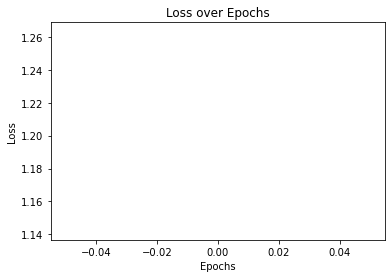

In [18]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the loss values
ax.plot(loss_values)

# Set lables and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Loss over Epochs')

# Display the plot
plt.show()

In [19]:
model.eval() # Set the model to evaluation mode

val_loss = 0.0

with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        inputs_x = inputs.float()
        #inputs_x = torch.mean(inputs_x, dim=1, keepdim=True)
        b, c, d, h, w = inputs_x.shape
        inputs_x = inputs_x.permute(0,1,2,3,4)
        outputs = model(inputs_x)
        labels = labels.float()
        b,c,d,h,w = inputs_x.shape
        val_loss += criterion(outputs, labels).item()

print('Validation loss: %.3f' % (val_loss / len(val_loader)))

conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.view: torch.Size([32, 1769472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.view: torch.Size([32, 1769472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.view: torch.Size([32, 1769472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.view: torch.Size([32, 1769472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.v

In [31]:
correct = 0
total = 0

with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        inputs_x = inputs.float()
        #inputs_x = torch.mean(inputs_x, dim=1, keepdim=True)
        b, c, d, h, w = inputs_x.shape
        inputs_x = inputs_x.permute(0,1,2,3,4)
        outputs = model(inputs_x)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        #total += labels.size(0)
        #correct += (predicted == labels).sum().item()

#print('Validation accuracy: %.3f %%' % (100 * correct / total))

conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.view: torch.Size([32, 1769472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.view: torch.Size([32, 1769472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.view: torch.Size([32, 1769472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
conv

## Confusion Matrix


## Val. Evaluate the model

In [33]:
#%% capture
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        # covert images and lables to Double tensor
        images = images.float()
        labels = labels.long()
        ouputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.sum().item())

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
      

conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.view: torch.Size([32, 1769472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.view: torch.Size([32, 1769472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.view: torch.Size([32, 1769472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.view: torch.Size([32, 1769472])
x.nn.functional: torch.Size([32, 128])
fc2: torch.Size([32, 3])
conv1: torch.Size([32, 32, 48, 48, 48])
conv2: torch.Size([32, 64, 24, 24, 24])
conv3: torch.Size([32, 128, 24, 24, 24])
x.v

ValueError: only one element tensors can be converted to Python scalars